## 4.2 Stop right now, thank you very much

Nomes: Andressa Cristine M. Costa e Andriel Vinicius Martins da Silva

### 1. Objetivo: 
Implemente uma estratégia de Parada Antecipada (Early Stopping) no
processo de treino da rede neural feita em Python puro ou no processo de treino da rede
neural feita em PyTorch.

**Comentário:** esta não é para resolver com o módulo lightning.

### 2. Early Stopping:

A estratégia de Early Stopping consiste na implementação de um modo de parar o treinamento quando o desempenho do modelo para um determinado conjunto de dados de validação para de melhorar [1]. Esse tipo de estratégia é implementado para evitar o cenário de overfitting, que é quando o modelo se ajusta excessivamente aos dados de treino e acaba não ficando bom para prever os dados de validação. Assim, conseguiríamos melhorar o desempenho do modelo.


<div style="text-align: center;">
    <img src="imgs/Early%20Stopping.webp" alt="Early Stopping" width="300"/>
    <figcaption>Figura 1 - Exemplo de plots de curva de aprendizado. [1]</figcaption>
</div>

A ideia principal é monitorar o desempenho do modelo durante o treinamento e parar de treinar quando as curvas de aprendizado entre os dados de validação e os dados de treino começam a divergir (a distância entre os respectivos pontos entre as duas curvas começa a aumentar).

No caso da nossa implementação, essas curvas de aprendizado são plotadas em função da perda obtida para os dados de validação e os dados de treinamento. 




### 3. Implementação

**I) Escolha de dados:** O dataset escolhido para a implementação desse código foi o `penguins` da biblioteca seaborn. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = sns.load_dataset('penguins').dropna() 

A importação de dados foi conduzida normalmente com a implementação de um método dropna() para remover possíveis valores de NaN. Após isso, foi implementada uma normalização dos dados de entrada conforme sugestão do professor para tentar melhorar o desempenho do modelo.

**II) Tratamento dos dados:** nessa etapa os dados foram normalizados via método `MinMaxScaler` da biblioteca `sklearn`, no qual converte os dados para um intevalo de 0 a 1.

- Escolheu-se as seguintes **features** para o problema: `bill_length_mm, bill_depth_mm, flipper_length_mm`, sendo comprimento do bico, profundidade do bico e comprimento da nadadeira, todos em milímetros, respectivamente. E o **target** escolhido `body_mass_g`, se refere a massa corporal em gramas dos penguins.

In [3]:
from sklearn.preprocessing import MinMaxScaler

features = df[["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]]

normalizador = MinMaxScaler()

normalizador.fit(features)

features = normalizador.transform(features)

Nessa etapa foi necessário consultar [2] para converter os dados de features para o formato correto para o uso com torch, convertendo de uma dataframe para um tensor e do formato float 64 para o 32.

In [4]:
x = torch.from_numpy(features.astype(np.float32))
x.dtype

torch.float32

In [5]:
target = df["body_mass_g"].values
target = target.reshape(-1, 1)

In [6]:
normalizador = MinMaxScaler()

normalizador.fit(target)

target = normalizador.transform(target)

In [7]:
y = torch.from_numpy(target.astype(np.float32))

**III) Criação da Rede Neural:** O trecho abaixo trata-se da criação da rede neural com a utilização da biblioteca `pyTorch`.

In [8]:
class MLP(nn.Module):
    def __init__(self, num_dados_entrada, neuronios_c1, num_targets):
        super().__init__()
        
        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, num_targets),
        )
        
    def forward(self, x):
        x = self.camadas(x)
        return x

In [9]:
NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1
NEURONIOS_C1 = 121

minha_mlp = MLP(
    NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NUM_DADOS_DE_SAIDA
)

In [10]:
TAXA_DE_APRENDIZADO = 0.003

otimizador = optim.SGD(minha_mlp.parameters(), lr=TAXA_DE_APRENDIZADO)

In [11]:
fn_perda = nn.MSELoss()

**IV) Split dos dados:** Divisão dos dados de testes, treino e validação.

In [12]:
x_train, x_20, y_train, y_20 = train_test_split(x, y, test_size=0.20, random_state=42)

x_val, x_teste, y_val, y_teste = train_test_split(x_20, y_20, test_size=0.25, random_state=42)

**V) Execução da Rede Neural** 

In [13]:
NUM_EPOCAS = 100

minha_mlp.train()

fator_de_parada = 100

melhora_minima = 0.01

contador_de_parada = 0

melhor_perda = float('inf')

l_val = []
l_train = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = minha_mlp(x_train)

    # zero grad
    otimizador.zero_grad()

    # loss
    loss = fn_perda(y_train.view(-1, 1), y_pred.view(-1, 1))

    # backpropagation
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    l_train.append(loss.item())

    minha_mlp.eval()
    
    val_loss = 0
    with torch.no_grad():
        for x_v, y_v in zip(x_val, y_val.view(-1, 1)):
            y_pred = minha_mlp(x_v)
            val_loss += fn_perda(y_v, y_pred).item() #calcula a perda a partir da difereça entre o real e o predito

    val_loss /= len(y_val)
    l_val.append(val_loss)
    minha_mlp.train()

    if val_loss < melhor_perda - melhora_minima:
        melhor_perda = val_loss
        contador_de_parada = 0
    else:
        contador_de_parada += 1
        if contador_de_parada == fator_de_parada:
            print(f"Parada antecipada na epoca: {epoca}")
            break

### Implementação do Early Stopping

```python 
 minha_mlp.eval()
    
    val_loss = 0
    with torch.no_grad():
        for x_v, y_v in zip(x_val, y_val.view(-1, 1)):
            y_pred = minha_mlp(x_v)
            val_loss += fn_perda(y_v, y_pred).item()

    val_loss /= len(y_val)
    l_val.append(val_loss)
    minha_mlp.train()

    if val_loss < melhor_perda - melhora_minima:
        melhor_perda = val_loss
        contador_de_parada = 0
    else:
        contador_de_parada += 1
        if contador_de_parada == fator_de_parada:
            print(f"Parada antecipada na epoca: {epoca}")
            break
```

O código acima traz a implementação do Early Stopping [1]. Primeiramente, alternando do modo de treino para o modo de teste e calculamos a função de perda para a predição da rede até o momento. Com esse valor de perda, observa-se a variação entre as perdas de treino e de validação; caso essa diferença seja maior do que nas iterações anteriores, o algoritmo encerra sua execução.

Um fator de melhora mínima pode ser aplicado para indicar o quanto será necessário que o valor de perda seja reduzido em relação ao valor anterior. Além disso, há um contador de paradas, responsável por indicar quantas vezes o código ainda pode rodar após ser alcançado um valor de perda maior que o atual.

**VI) Plotagem das perdas:** Foram reunidas as perdas durante as etapas de treino e validação para comparação via gráfico.

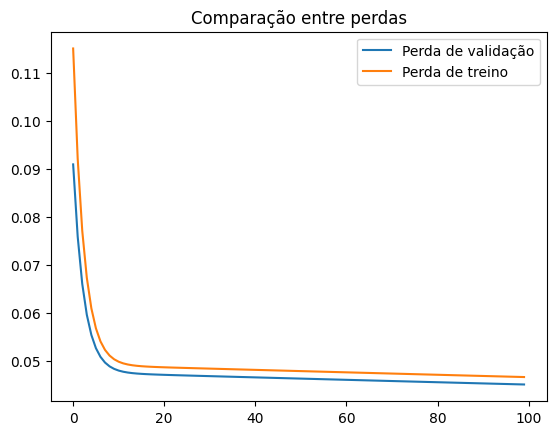

In [14]:
from matplotlib import pyplot as plt

x = list(range(0, len(l_val)))

plt.plot(x, l_val, label = 'Perda de validação')
plt.plot(x, l_train, label = 'Perda de treino')

plt.title('Comparação entre perdas')
plt.legend()
plt.show()

O gráfico acima se comporta de forma um pouco diferente do esperado, de acordo com a imagem apresentada na introdução. Isso se deve ao fato de o dataset escolhido ser didático, contendo dados com uma correlação clara.

**VII) Teste e calculo do RMSE**

In [15]:
minha_mlp.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=3, out_features=121, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=121, out_features=1, bias=True)
  )
)

In [16]:
with torch.no_grad():
    y_pred = minha_mlp(x_teste)

In [17]:
y_teste = normalizador.inverse_transform(y_teste)

In [18]:
y_pred = normalizador.inverse_transform(y_pred)

In [19]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(y_teste, y_pred, squared=False)
print(RMSE)

741.8500402510997


### 4. Conclusão
Analisando o valor de RMSE obtido, percebe-se um resultado insatisfatório no que diz respeito à predição. Porém, isso ocorre devido às limitações do dataset escolhido e à falta de otimização dos hiperparâmetros. No entanto, considerando o objetivo principal — a aplicação do Early Stopping — o código apresentou o comportamento esperado, encerrando a execução assim que a taxa de aprendizado começou a divergir.

### 5. Referências

[1]. CYBORG. What is Early Stopping in Deep Learning? - Cyborg - Medium. Disponível em: <https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf>.

[2]‌. DSA, E. Capítulo 28 - Usando Early Stopping Para Definir o Número de Épocas de Treinamento - Deep Learning Book. Disponível em: <https://www.deeplearningbook.com.br/usando-early-stopping-para-definir-o-numero-de-epocas-de-treinamento/>.

[3]. GEEKSFORGEEKS. Converting a Pandas DataFrame to a PyTorch Tensor. Disponível em: https://www.geeksforgeeks.org/converting-a-pandas-dataframe-to-a-pytorch-tensor/. Acesso em: 9 jun. 2025.

[4]. STACK OVERFLOW. Convert numpy array type and values from float64 to float32. Disponível em: https://stackoverflow.com/questions/45955186/convert-numpy-array-type-and-values-from-float64-to-float32. Acesso em: 9 jun. 2025.

[5]. train_test_split. Disponível em: <http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>. Acesso em: 9 jun. 2025.